# Similarity-Based Constraint Score For Feature Selection Notebook

In this notebook, you will find a comprehensive summary of the project, detailing key steps undertaken and presenting results obtained during the implementation of our innovative constraint score.



In [1]:
%cd /Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS
import numpy as np
import pandas as pd
import sklearn.datasets as skd
from sklearn.preprocessing import StandardScaler
from c_scores import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as Knn
import matplotlib.pyplot as plt

/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS


### Wine dataset

In [2]:
# Loding the wine data
WineDB = skd.load_wine()
X = WineDB.data
y = WineDB.target

X_wine = np.concatenate((X, y.reshape(-1, 1)), axis=1)
X_train_wine , X_test_wine = split_dataset(X_wine)

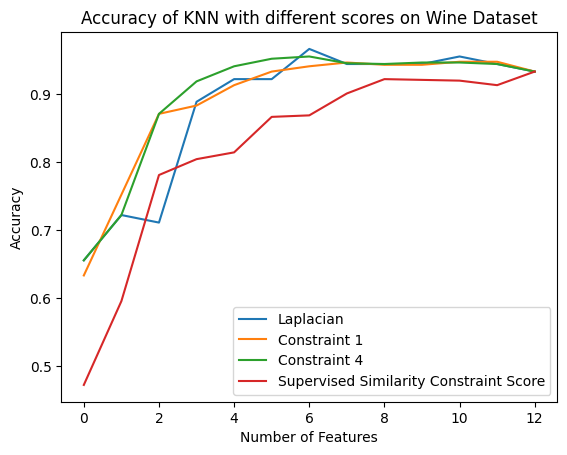

In [4]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_wine, X_test_wine,10,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]


plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Supervised Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Wine Dataset')

plt.legend()


In [5]:
auc_laplacian = auc_score(accuracy_laplacian)
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Laplacian: ', auc_laplacian)
print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 4: ', auc_constraint_4)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Laplacian:  0.82008547008547
AUC of Constraint 1:  0.8312820512820512
AUC of Constraint 4:  0.8371794871794873
AUC of Similarity Constraint Score:  0.7701282051282051


In [6]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
R = rank_matrix(scores,X_train_wine,5,3)

In [7]:
R_matrix_laplacian = R[0]
R_matrix_constraint_1 = R[1]
R_matrix_constraint_4 = R[2]
R_matrix_similarity_constraint = R[3]

In [8]:
print(R_matrix_constraint_1)
print(R_matrix_constraint_4)
print(R_matrix_similarity_constraint)

[[12.  6. 11.  2.  0.  9.  5.  7.  8. 10.  4.  1.  3.]
 [12.  6.  1. 11.  4. 10.  8.  3.  9.  2.  0.  7.  5.]
 [11.  6.  9.  5. 12. 10.  8.  0.  1.  7.  3.  2.  4.]
 [12.  6.  0. 11.  9.  2. 10.  5.  7.  1.  4.  3.  8.]
 [ 4.  6. 12.  5.  0.  9. 11.  7.  1.  8. 10.  2.  3.]]
[[12.  4.  2.  0.  3.  6. 11. 10.  7.  9.  5.  8.  1.]
 [12.  4.  3.  2.  0.  6. 11. 10.  7.  9.  8.  5.  1.]
 [12.  4.  3. 11.  0.  2.  6. 10.  9.  5.  7.  8.  1.]
 [12.  4.  0.  2.  3.  6. 11. 10.  9.  7.  5.  8.  1.]
 [12.  4.  0.  3.  2.  6. 11. 10.  5.  9.  7.  8.  1.]]
[[ 2.  3.  4.  5.  1.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 2.  3.  4.  5.  1.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.  0.]]


## OTHER DATA SETS ( Vehicule,Image Segmentation,WBCD,Ionosphere,Libras Movement,CNAE-9)

### Vehicules

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_vehicle_silhouettes = fetch_ucirepo(id=149)

# data (as pandas dataframes)
X = statlog_vehicle_silhouettes.data.features
y = statlog_vehicle_silhouettes.data.targets

# pandas to numpy
X = X.values
y = y.values


# get classes and their counts
classes, counts = np.unique(y, return_counts=True)

ind_204 = np.where(y == '204')[0]

# remove class 204
X = np.delete(X, ind_204, axis=0)
y = np.delete(y, ind_204)

# encode the classes to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


data_vehicles = np.concatenate((X,y[np.newaxis].T), axis=1)
data_vehicles = split_dataset(data_vehicles)[0]

X_train_vehicle, X_test_vehicle = split_dataset(data_vehicles)

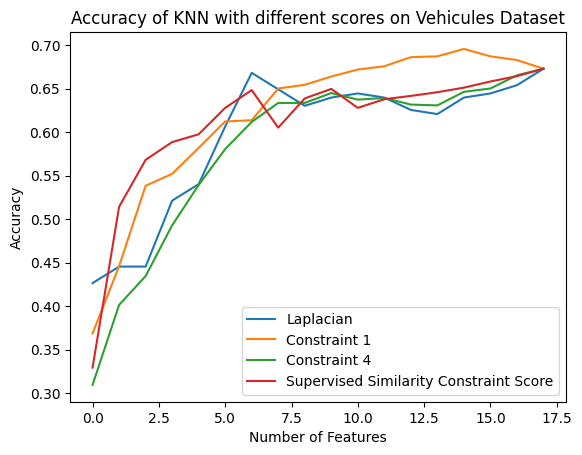

In [7]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_vehicle, X_test_vehicle,10,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]


plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Supervised Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Vehicules Dataset')

plt.legend()

In [8]:
auc_laplacian = auc_score(accuracy_laplacian)
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Laplacian: ', auc_laplacian)
print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 4: ', auc_constraint_4)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Laplacian:  0.5647709320695103
AUC of Constraint 1:  0.5900737230121116
AUC of Constraint 4:  0.5536466561348078
AUC of Similarity Constraint Score:  0.5815297525013166


### Image Segmentation Dataset

In [21]:
image_segmentation = pd.read_csv('./sim_based_cs/data/segmentation.csv')
image_segmentation.head()
# get the features and the target in numpy format
X = image_segmentation.iloc[:, 1:].values
y = image_segmentation.iloc[:,0].values

# encode the classes to integers
le = LabelEncoder()
y = le.fit_transform(y)

data_segmentation = np.concatenate((X,y[np.newaxis].T), axis=1)

X_train_image_seg, X_test_image_seg = split_dataset(data_segmentation)

/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:104: RuntimeWarning: invalid value encountered in divide
  constraint_score_1 = constraint_score_1_num / constraint_score_1_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:104: RuntimeWarning: invalid value encountered in divide
  constraint_score_1 = constraint_score_1_num / constraint_score_1_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:104: RuntimeWarning: invalid value encountered in divide
  constraint_score_1 = constraint_score_1_num / constraint_score_1_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:104: RuntimeWarning: invalid value encountered in divide
  constraint_score_1 = constraint_score_1_num / constraint_score_1_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.p

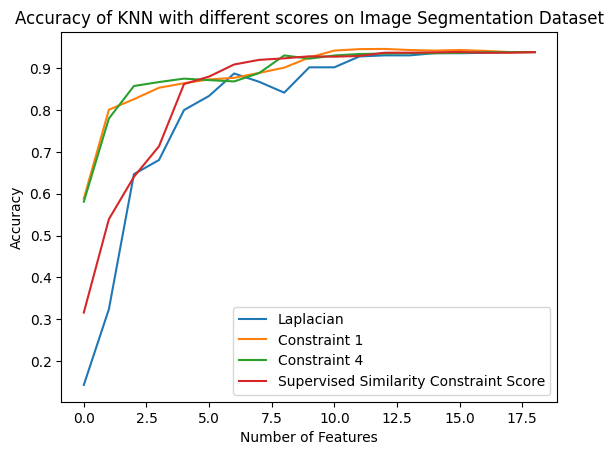

In [22]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_image_seg, X_test_image_seg,1,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]


plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Supervised Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Image Segmentation Dataset')

plt.legend()

In [23]:
auc_laplacian = auc_score(accuracy_laplacian)
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Laplacian: ', auc_laplacian)
print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 4: ', auc_constraint_4)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Laplacian:  0.777010708589656
AUC of Constraint 1:  0.8482478924584188
AUC of Constraint 4:  0.8476919571656414
AUC of Similarity Constraint Score:  0.8118637502848028


### Breast Cancer Wisconsin (Diagnostic) Data Set

In [9]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

X = X.values
y = y.values
le = LabelEncoder()
y = le.fit_transform(y)

data_WBCD = np.concatenate((X,y[np.newaxis].T), axis=1)
X_train_WBCD, X_test_WBCD = split_dataset(data_WBCD)

print(data_WBCD.shape)



(569, 31)


/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


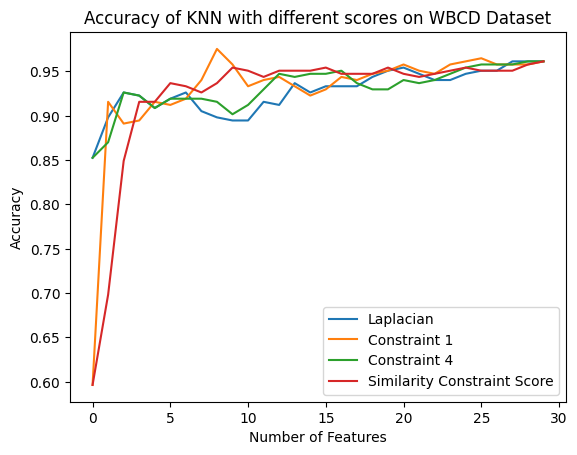

In [10]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_WBCD, X_test_WBCD,1,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]


plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on WBCD Dataset')

plt.legend()

In [11]:
auc_laplacian = auc_score(accuracy_laplacian)
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Laplacian: ', auc_laplacian)
print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 4: ', auc_constraint_4)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Laplacian:  0.8980701754385965
AUC of Constraint 1:  0.9033918128654972
AUC of Constraint 4:  0.9013450292397663
AUC of Similarity Constraint Score:  0.896608187134503


### Ionosphere Dataset

In [16]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
ionosphere = fetch_ucirepo(id=52)

# data (as pandas dataframes)
X = ionosphere.data.features
y = ionosphere.data.targets

X = X.values
y = y.values

y = le.fit_transform(y)

data_ionosphere = np.concatenate((X,y[np.newaxis].T), axis=1)
X_train_ionosphere, X_test_ionosphere = split_dataset(data_ionosphere)

/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:28: RuntimeWarning: invalid value encountered in divide
  laplacian_score_matrix = laplacian_score_num / laplacian_score_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:104: RuntimeWarning: invalid value encountered in divide
  constraint_score_1 = constraint_score_1_num / constraint_score_1_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:28: RuntimeWarning: invalid value encountered in divide
  laplacian_score_matrix = laplacian_score_num / laplacian_score_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:104: RuntimeWarning: invalid value encountered in divide
  constraint_score_1 = constraint_score_1_num / constraint_score_1_den
/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/sim_based_cs/c_scores.py:28: 

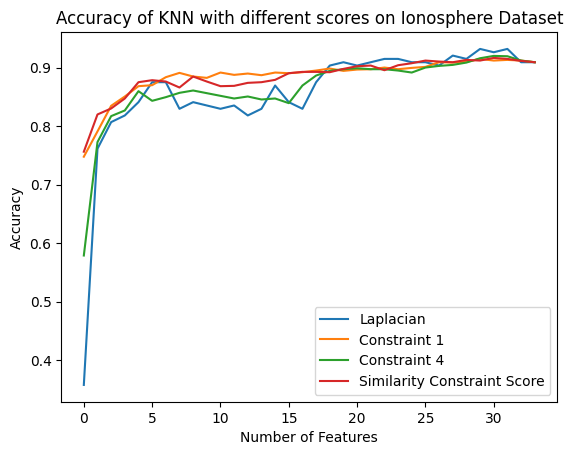

In [19]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_ionosphere, X_test_ionosphere,10,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]


plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Ionosphere Dataset')

plt.legend()

In [20]:
auc_laplacian = auc_score(accuracy_laplacian)
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Laplacian: ', auc_laplacian)
print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 4: ', auc_constraint_4)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Laplacian:  0.839822860962567
AUC of Constraint 1:  0.8609291443850268
AUC of Constraint 4:  0.8434575534759358
AUC of Similarity Constraint Score:  0.8596340240641712


### Libras Movement

In [12]:
### Libras Movement
libras_movement = pd.read_csv('./sim_based_cs/data/libras.csv')
libras_movement.head()
# get the features and the target in numpy format
X = libras_movement.iloc[:, :-1].values
y = libras_movement.iloc[:,-1].values


data_libras = np.concatenate((X,y[np.newaxis].T), axis=1)
X_train_libras, X_test_libras = split_dataset(data_libras)

In [20]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_libras, X_test_libras,10,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]

plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Libras Movement Dataset')

plt.legend()

In [18]:
print('AUC of Laplacian: ', auc_score(accuracy_laplacian))
print('AUC of Constraint 1: ', auc_score(accuracy_constraint_1))
print('AUC of Constraint 4: ', auc_score(accuracy_constraint_4))
print('AUC of Similarity Constraint Score: ', auc_score(accuracy_supervised_similarity_constraint))



AUC of Laplacian:  0.7066049382716049
AUC of Constraint 1:  0.6743518518518518
AUC of Constraint 4:  0.6763888888888889
AUC of Similarity Constraint Score:  0.8061419753086418


### CNAE-9

In [ ]:
cnae9 = pd.read_csv('./sim_based_cs/data/cnae-9.csv')
cnae9.head()
# get the features and the target in numpy format
X = cnae9.iloc[:,:-1].values
y = cnae9.iloc[:,-1].values

data_cnae9 = np.concatenate((X,y[np.newaxis].T), axis=1)
X_train_cnae9, X_test_cnae9 = split_dataset(data_cnae9)

In [ ]:
scores = [laplacian_score,constraint_score_1,constraint_score_4,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_cnae9, X_test_cnae9,10,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]

plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on CNAE-9 Dataset')

plt.legend()